In [1]:
#Get the iWidget stuff
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import os
import sys

sys.path.append('/home/michael/jupyter/local-packages')

# Get my Utilities (localUtilities)
from localUtilities import dateUtils  #bPyUtils, configIB 
from localUtilities.webScrape import getCompanEarningsFromYahoo

import numpy as np
import pandas as pd
import datetime
import random
import itertools
from IPython.display import display, HTML

# matplotlib imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

# interactive Shell to see variables outside of print() function - 
#  if this is on one can suppress output by adding a ';' at the end of line 
#   not 100% clear which variables this supresses 
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

# Doc is here: https://ib-insync.readthedocs.io/readme.html
from ib_insync import *
util.startLoop()

ib = IB()
# Connect to IB Gateway / Paper Trade 4002 
#            TWS        / Paper Trade 7495
ib.connect('127.0.0.1', 4002, clientId=8)

<IB connected to 127.0.0.1:4002 clientId=8>

In [2]:
#See if connected 
ib.isConnected()

True

In [3]:
theStock = 'AAPL'
contract = Stock(theStock, 'SMART', 'USD')

#get earnings from Yahoo
yahooEarningsDF = getCompanEarningsFromYahoo.getPastEarnings(theStock)
yahooEarningsDF

,Symbol,Earnings_Date,Company,EPS_Estimate,Reported_EPS,Surprise(%)
0,AAPL,2019-07-30 20:00:00,Apple Inc,2.1,2.18,+3.81
1,AAPL,2019-04-30 20:00:00,Apple Inc,2.36,2.46,+4.24
2,AAPL,2019-01-29 21:00:00,Apple Inc,4.17,4.18,+0.24
3,AAPL,2018-11-01 20:00:00,Apple Inc,2.78,2.91,+4.68
4,AAPL,2018-07-31 20:00:00,Apple Inc,2.18,2.34,+7.34
5,AAPL,2018-05-01 20:00:00,Apple Inc,2.67,2.73,+2.25
6,AAPL,2018-02-01 21:00:00,Apple Inc,3.86,3.89,+0.78
7,AAPL,2017-11-02 20:00:00,Apple Inc,1.87,2.07,+10.7
8,AAPL,2017-08-01 20:00:00,Apple Inc,1.57,1.67,+6.37
9,AAPL,2017-05-02 20:00:00,Apple Inc,2.02,2.1,+3.96


In [4]:
# # add daysAroundEarnings Days forward - this will be used to count back and plot time
# # durationString,The amount of time (or Valid Duration String units) to go back from the request's given end date and time.

# add X(daysPassEarnings) Days forward past earnings - this will be used to count back from endDateTime
daysPassEarnings = 60

# How far back from daysPassEarnings
durationStrDays = '90 D'
# Bar size
setBarSizeSetting = '1 day'

<p>Historical data is obtained from the the TWS via the&nbsp;<a class="el" href="https://interactivebrokers.github.io/tws-api/classIBApi_1_1EClient.html#a5eac5b7908b62c224985cf8577a8350c">IBApi.EClient.reqHistoricalData</a>&nbsp;function. Every request needs:</p>
<ul>
<li><em><strong>tickerId</strong></em>, A unique identifier which will serve to identify the incoming data.</li>
<li><em><strong>contract</strong></em>, The&nbsp;<a class="el" href="https://interactivebrokers.github.io/tws-api/classIBApi_1_1Contract.html">IBApi.Contract</a>&nbsp;you are interested in.</li>
<li><em><strong>endDateTime</strong></em>, The request's end date and time (the empty string indicates current present moment).</li>
<li><em><strong>durationString</strong></em>, The amount of time (or&nbsp;<a class="el" href="https://interactivebrokers.github.io/tws-api/historical_bars.html#hd_duration">Valid Duration String units</a>) to go back from the request's given end date and time.</li>
<li><em><strong>barSizeSetting</strong></em>, The data's granularity or&nbsp;<a class="el" href="https://interactivebrokers.github.io/tws-api/historical_bars.html#hd_barsize">Valid Bar Sizes</a></li>
<li><em><strong>whatToShow</strong></em>, The type of data to retrieve. See&nbsp;<a class="el" href="https://interactivebrokers.github.io/tws-api/historical_bars.html#hd_what_to_show">Historical Data Types</a></li>
<li><em><strong>useRTH</strong></em>, Whether (1) or not (0) to retrieve data generated only within Regular Trading Hours (RTH)</li>
<li><em><strong>formatDate</strong></em>, The format in which the incoming bars' date should be presented. Note that for day bars, only yyyyMMdd format is available.</li>
<li><em><strong>keepUpToDate</strong></em>, Whether a subscription is made to return updates of unfinished real time bars as they are available (True), or all data is returned on a one-time basis (False).&nbsp;<em>Available starting with API v973.03+ and TWS v965+</em>. If&nbsp;<em>True</em>, and endDateTime cannot be specified.</li>
<li></li>
</ul>

In [5]:
#create time series panda dataframes from IB
earningsPastStock = []
earningsPastImpVol=[]

# Get Historical Data
for earnData in range(0, len(yahooEarningsDF)):
        earningsPastStock.append(util.df(ib.reqHistoricalData(contract, endDateTime=yahooEarningsDF['Earnings_Date'][earnData]
                                                              +datetime.timedelta(days=daysPassEarnings),  
                                                              durationStr=durationStrDays,barSizeSetting=setBarSizeSetting, 
                                                              whatToShow='TRADES', useRTH=True)))
        earningsPastImpVol.append(util.df(ib.reqHistoricalData(contract, endDateTime=yahooEarningsDF['Earnings_Date'][earnData]
                                                               +datetime.timedelta(days=daysPassEarnings), 
                                                               durationStr=durationStrDays,barSizeSetting=setBarSizeSetting, 
                                                               whatToShow='OPTION_IMPLIED_VOLATILITY', useRTH=True)))

# earningsPastStock
# earningsPastImpVol        

In [6]:
listOfEarningDeltas = []

# Get Min/Max Price/Percent in data set 
for count in range(0, len(yahooEarningsDF)): # for all the dates in earningsCalendar
    # recreate index as the 'date' column 
    ePSPrice = earningsPastStock[count].set_index("date", drop=False)
    ePSPrice.index = pd.to_datetime(ePSPrice.index)

    # Get Earning Date and Past/Forward + Plus1 Day
    onEarningDate = yahooEarningsDF['Earnings_Date'][count].date()
    onEarningDatePast = onEarningDate - datetime.timedelta(days=15)
    onEarningDateForward = onEarningDate + datetime.timedelta(days=15)

    
    # Create new dataframe from old // old[['A', 'C', 'D']].copy()
    # Create a new df and set index to date
    onEarningDatePastdf=(ePSPrice.loc[onEarningDatePast:onEarningDateForward,['date','close']].copy()).set_index("date", drop=False)

    anEarningDate=yahooEarningsDF['Earnings_Date'][count].date()   
    
    # Let’s add a new column ‘earningDayPercentDelta’ where entry at each index will be calculated by the values in other columns at that index i.e.
    # dfObj['Percentage'] =  (100-(dfObj['Marks'] / dfObj['Total'] ) * 100

    onEarningDatePastdf['$Deltas'] = round((onEarningDatePastdf['close'] - ePSPrice.close.at[anEarningDate]),2)
    onEarningDatePastdf['%Deltas'] = round(100-((ePSPrice.close.at[anEarningDate]/onEarningDatePastdf['close'])*100),2)
    
    # keep a list of DF of these $ & % updates  ayAfterMove%
#     onEarningDatePastdf['earningDayPriceDelta'] = round((onEarningDatePastdf['close'] - ePSPrice.close.at[anEarningDate]),2)
#     onEarningDatePastdf['earningDayPercentDelta'] = round(100-((ePSPrice.close.at[anEarningDate]/onEarningDatePastdf['close'])*100),2)
    
    listOfEarningDeltas.append(onEarningDatePastdf)   
    

In [7]:
# onEarningDatePlus1DateTime = anEarningDate + datetime.timedelta(days=1)
# dateUtils.getDateStringDashSeprtors(onEarningDatePlus1)
# onEarningDatePlus1DateTime

In [9]:
    
# onEarningDatePlus1 = dateUtils.getDateStringDashSeprtors(onEarningDatePlus1DateTime)   
maxPriceDelta=[]
maxPercentDelta=[]
minPriceDelta=[]
minPercentDelta=[]
priceDelta1Day=[]
percentDelta1Day=[]

# Count for number of earnings in Yahoo Earnings / yahooEarningsDF
count = 0 
for earnDateDF in listOfEarningDeltas:
    # Get earning date
    anEarningDate=yahooEarningsDF['Earnings_Date'][count].date()
    # Get Earning date +1
    onEarningDatePlus1 = anEarningDate + datetime.timedelta(days=1)

    # Get Max/Min % / $
    maxPriceDelta.append(earnDateDF['$Deltas'].max())
    maxPercentDelta.append(earnDateDF['%Deltas'].max())
    minPriceDelta.append(earnDateDF['$Deltas'].min())
    minPercentDelta.append(earnDateDF['%Deltas'].min())

    # Get earning day + 1 info
    priceDelta1Day.append(earnDateDF.loc[onEarningDatePlus1,'$Deltas'])
    percentDelta1Day.append(earnDateDF.loc[onEarningDatePlus1,'%Deltas'])

    # Count for number of earnings in Yahoo Earnings / yahooEarningsDF
    count = count +1



In [10]:
# add info to yahooEarningsDF dataframe
yahooEarningsDF['$Max']=maxPriceDelta
yahooEarningsDF['%Max']=maxPercentDelta
yahooEarningsDF['$Min']=minPriceDelta
yahooEarningsDF['%Min']=minPercentDelta
yahooEarningsDF['dayAfter%']=percentDelta1Day
yahooEarningsDF['dayAfter$']=priceDelta1Day
yahooEarningsDF

,Symbol,Earnings_Date,Company,EPS_Estimate,Reported_EPS,Surprise(%),$Max,%Max,$Min,%Min,dayAfter%,dayAfter$
0,AAPL,2019-07-30 20:00:00,Apple Inc,2.1,2.18,+3.81,4.26,2.00,-6.19,-3.06,2.00,4.26
1,AAPL,2019-04-30 20:00:00,Apple Inc,2.36,2.46,+4.24,11.08,5.23,-14.95,-8.05,4.68,9.85
2,AAPL,2019-01-29 21:00:00,Apple Inc,4.17,4.18,+0.24,19.56,11.23,-4.68,-3.12,6.40,10.57
3,AAPL,2018-11-01 20:00:00,Apple Inc,2.78,2.91,+4.68,0.51,0.23,-35.42,-18.96,-7.10,-14.74
4,AAPL,2018-07-31 20:00:00,Apple Inc,2.18,2.34,+7.34,19.95,9.49,-0.38,-0.20,5.56,11.21
5,AAPL,2018-05-01 20:00:00,Apple Inc,2.67,2.73,+2.25,20.94,11.02,-6.78,-4.18,4.23,7.47
6,AAPL,2018-02-01 21:00:00,Apple Inc,3.86,3.89,+0.78,11.48,6.40,-12.63,-8.14,-4.54,-7.28
7,AAPL,2017-11-02 20:00:00,Apple Inc,1.87,2.07,+10.7,8.13,4.61,-12.13,-7.78,2.54,4.39
8,AAPL,2017-08-01 20:00:00,Apple Inc,1.57,1.67,+6.37,11.55,7.15,-1.32,-0.89,4.51,7.09
9,AAPL,2017-05-02 20:00:00,Apple Inc,2.02,2.1,+3.96,8.59,5.50,-6.83,-4.85,-0.31,-0.45


In [ ]:

display(HTML(priceHeader))
print('Earning Price Max:  ', onEarningDatePastdf.earningDayPriceDelta.max())
print('Earning Price Min:  ', onEarningDatePastdf.earningDayPriceDelta.min())
print('Earning Price Max % Delta:  ', onEarningDatePastdf.earningDayPercentDelta.max())
print('Earning Price Min % Delta:  ', onEarningDatePastdf.earningDayPercentDelta.min())
display(onEarningDatePastdf)

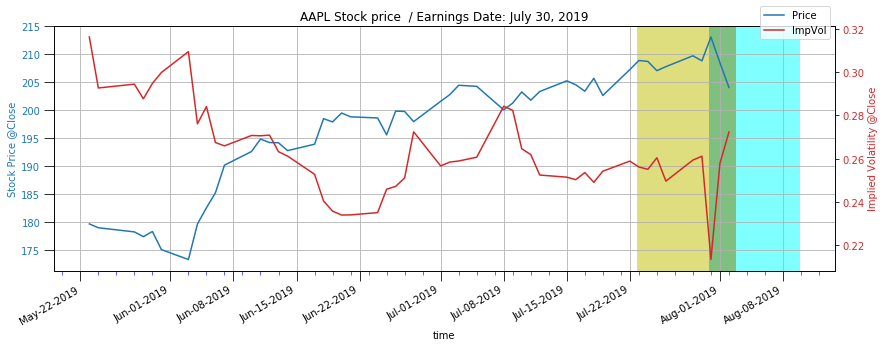

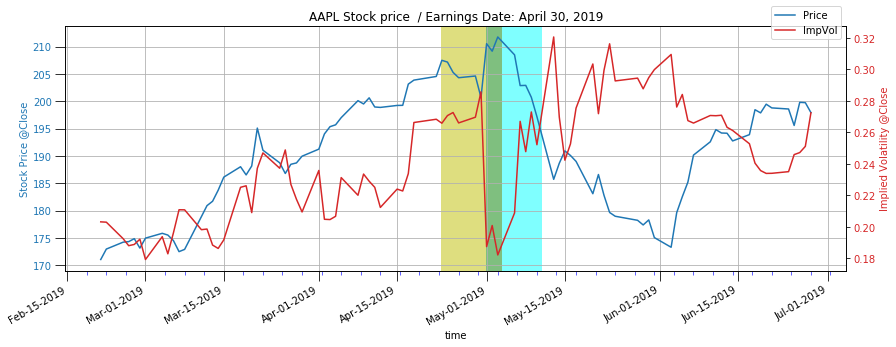

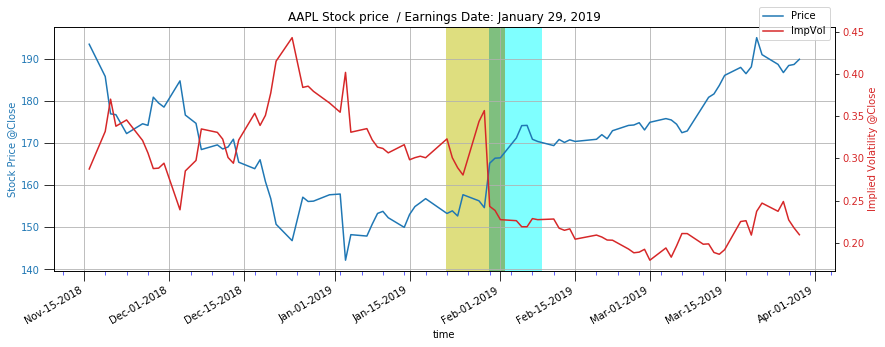

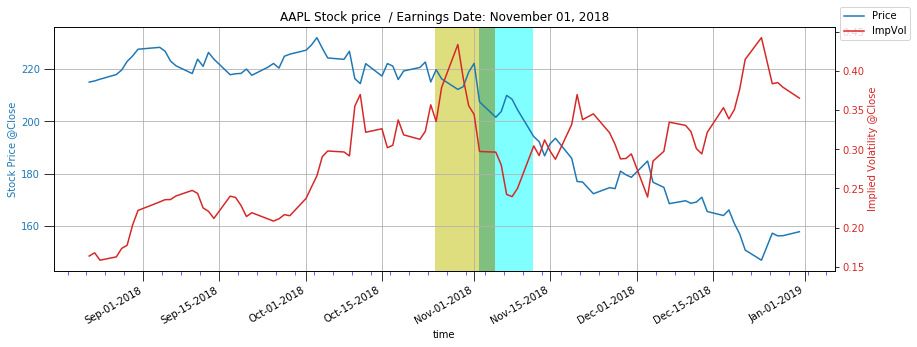

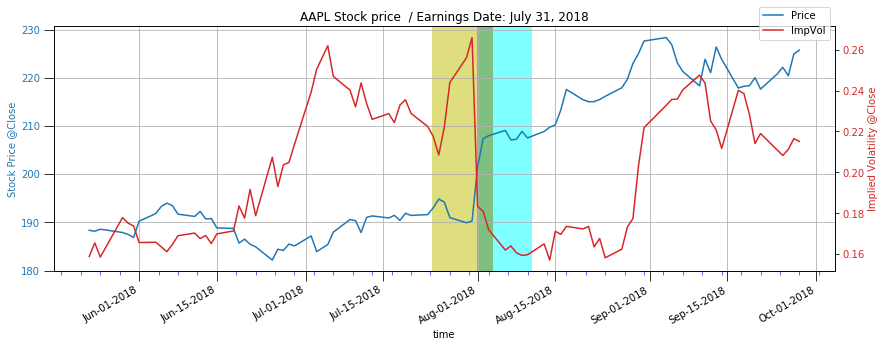

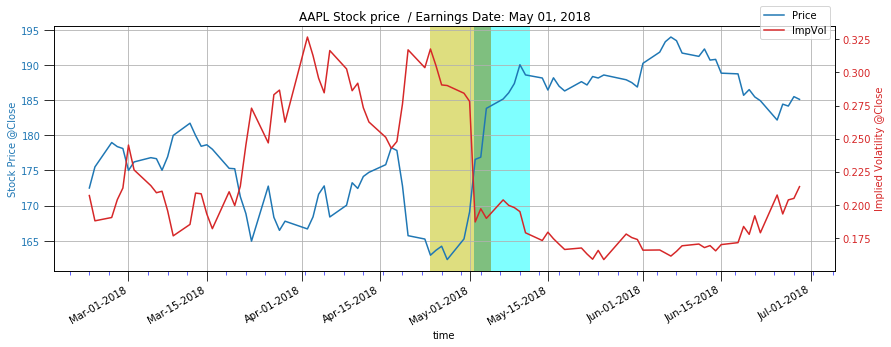

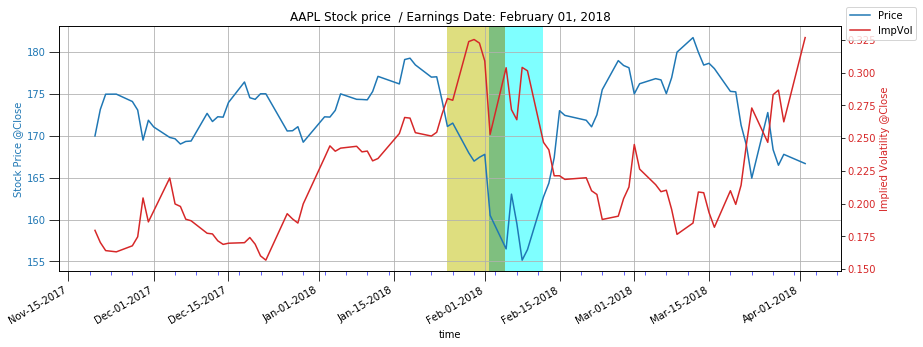

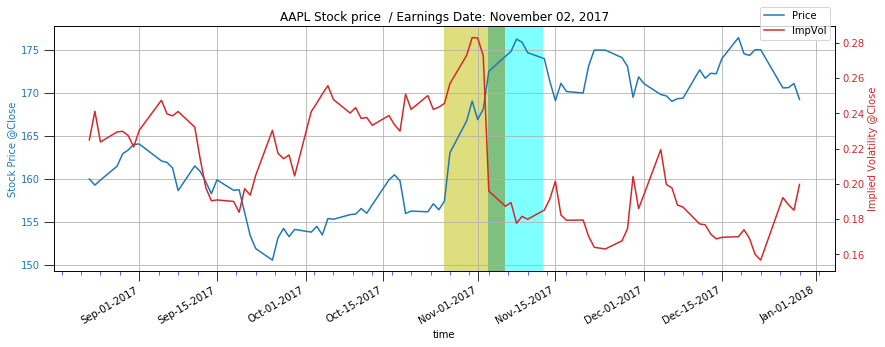

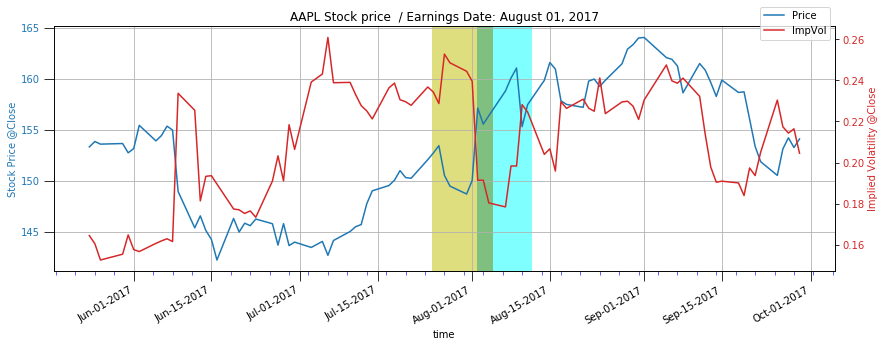

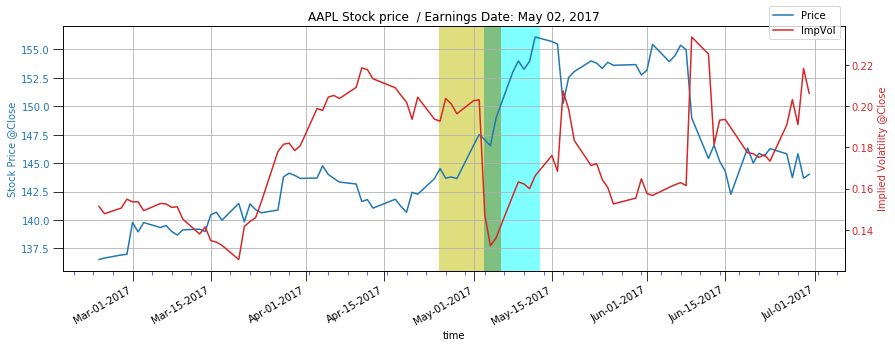

,Symbol,Earnings_Date,Company,EPS_Estimate,Reported_EPS,Surprise(%),$Max,%Max,$Min,%Min,dayAfter%,dayAfter$
0,AAPL,2019-07-30 20:00:00,Apple Inc,2.1,2.18,+3.81,4.26,2.00,-6.19,-3.06,2.00,4.26
1,AAPL,2019-04-30 20:00:00,Apple Inc,2.36,2.46,+4.24,11.08,5.23,-14.95,-8.05,4.68,9.85
2,AAPL,2019-01-29 21:00:00,Apple Inc,4.17,4.18,+0.24,19.56,11.23,-4.68,-3.12,6.40,10.57
3,AAPL,2018-11-01 20:00:00,Apple Inc,2.78,2.91,+4.68,0.51,0.23,-35.42,-18.96,-7.10,-14.74
4,AAPL,2018-07-31 20:00:00,Apple Inc,2.18,2.34,+7.34,19.95,9.49,-0.38,-0.20,5.56,11.21
5,AAPL,2018-05-01 20:00:00,Apple Inc,2.67,2.73,+2.25,20.94,11.02,-6.78,-4.18,4.23,7.47
6,AAPL,2018-02-01 21:00:00,Apple Inc,3.86,3.89,+0.78,11.48,6.40,-12.63,-8.14,-4.54,-7.28
7,AAPL,2017-11-02 20:00:00,Apple Inc,1.87,2.07,+10.7,8.13,4.61,-12.13,-7.78,2.54,4.39
8,AAPL,2017-08-01 20:00:00,Apple Inc,1.57,1.67,+6.37,11.55,7.15,-1.32,-0.89,4.51,7.09
9,AAPL,2017-05-02 20:00:00,Apple Inc,2.02,2.1,+3.96,8.59,5.50,-6.83,-4.85,-0.31,-0.45


In [11]:
colorStock = 'tab:blue'
colorImpVol = 'tab:red'
xLabel = 'time'
yLabelStock = 'Stock Price @Close';
yLabelImpVol = 'Implied Volatility @Close';
ax1LegendLabel = "Price"
ax2LegendLabel = "ImpVol"

locator = mdates.AutoDateLocator(minticks=5, maxticks=15)
formatter = mdates.ConciseDateFormatter(locator)
myFmt = DateFormatter("%b-%d-%Y")


for earn in range(0, len(yahooEarningsDF)): # for all the dates in earningsCalendar
    fig, ax1 = plt.subplots(figsize=(14,5)); # single Plot

    earningDateString = yahooEarningsDF['Earnings_Date'][earn].strftime("%B %d, %Y")
    theTitle = theStock + " Stock price "+ " / Earnings Date: " + earningDateString
    impVolDataHeaderStockString = '<hr> <strong><span style="color: #ff0000; font-family: arial, helvetica, sans-serif; font-size: large;"> ' + theStock 

    dataHeaderEarningDateString = '<br></span></strong><span style="font-size: small; color: #008000;"><strong><span style="font-family: arial, helvetica, sans-serif;">Earning Date &#9884 ' \
    + earningDateString + '<hr> '
    
    impVolDataHeader = impVolDataHeaderStockString  + ' &#9830; ImpVol ' + dataHeaderEarningDateString
    
    priceHeaderDataHeaderStockString = '<hr> <strong><span style="color: blue; font-family: arial, helvetica, sans-serif; font-size: large;"> ' + theStock 

    priceHeader = priceHeaderDataHeaderStockString  + ' &#9830; Price ' + dataHeaderEarningDateString

    
    
    ax1.set_title(theTitle);

    ax1.set_xlabel(xLabel);
    ax1.set_ylabel(yLabelStock, color=colorStock);
    ax1.plot(earningsPastStock[earn]['date'], earningsPastStock[earn]['close'], color=colorStock, label=ax1LegendLabel);
    ax1.tick_params(axis='y', labelcolor=colorStock);
    ax1.grid(True);

    # instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx();
    ax2.set_ylabel(yLabelImpVol, color=colorImpVol)  # we already handled the x-label with ax1
    ax2.plot(earningsPastImpVol[earn]['date'] ,earningsPastImpVol[earn]['close'], color=colorImpVol, label=ax2LegendLabel)
    ax2.tick_params(axis='y', labelcolor=colorImpVol)

    #build Legend for 2 Xaxis
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, bbox_to_anchor=(1.0, 1.1))

    #set up Major/Minor xAxis 
    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)

    # Format xAxis Date
    ax1.xaxis.set_major_formatter(myFmt)
    ax1.tick_params(which='major', length=10)
    ax1.tick_params(which='minor', length=4, color='b')
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    
    ax1.axvspan(mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]),
                mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]+datetime.timedelta(days=3)),
                facecolor='g', alpha=0.5)
    ax1.axvspan(mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]),
                mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]-datetime.timedelta(days=8)),
                facecolor='y', alpha=0.5)
    ax1.axvspan(mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]+datetime.timedelta(days=3)),
                mdates.date2num(yahooEarningsDF['Earnings_Date'][earn]+datetime.timedelta(days=10)),
                facecolor='aqua', alpha=0.5)

    fig.autofmt_xdate()
    plt.show()
yahooEarningsDF    
